SOM_uncertainty.ipynb

Estimates systematic and statstical uncertainty in SOM assignment.

As defined in La Torre+24:\
<b>Systematic</b>: uncertainty from the distribution of a parameter within a given cell \
<b>Statistical</b>: uncertainty from what cell a galaxy falls into, because of photometric uncertainty

In [2]:
import os
from glob import glob

import fitsio
from fitsio import FITS

import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured, append_fields
from numpy.lib.recfunctions import structured_to_unstructured as unstr

from mpdg_functions import load_KiDS_data

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('/Users/leo/Projects/mass_profile_dg/code/mpdg.mplstyle')

import somoclu

# Drawing many galaxies from one cell

In [2]:
folder = '/Users/leo/Projects/mass_profile_dg/saved_SOMs/09Aug24_mag_cut_20p5'
KiDS_predicted = FITS(f'{folder}/predicted_catalog.fits')[1]

labeled_map = np.load(f'{folder}/labeled_map.npy',
                      allow_pickle = True)
labeled_map_values = np.load(f'{folder}/labeled_map_values.npy',
                      allow_pickle = True)
data_bmus = np.load(f'{folder}/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load(f'{folder}/labeling_bmus.npy',
                      allow_pickle = True)

In [3]:
KiDS_catalog_path = '/Users/leo/Projects/mass_profile_dg/data_products/SOM_catalogs/KiDS/KiDS_SOM_panchrom_07Aug24/KiDS_SOM_panchrom_07Aug24_sec1.fits'

In [4]:
KiDS_data_sec1, _ = load_KiDS_data(KiDS_catalog_path)

In [5]:
column_names     = KiDS_data_sec1.dtype.names
color_names      = [name for name in column_names if name.endswith('col')]
color_std_names  = [name for name in column_names if name.endswith('col_err')]

data_names = ['r_mag'] + color_names
data_names += ['half_light_radius']
data_names += ['redshift']

std_names = ['r_mag_err'] + color_std_names
# std_names += ['half_light_radius_err']

In [6]:
def draw_new_galaxy(means, stds):
    return [np.random.normal(means[i], stds[i]) for i in range(len(means))]

In [7]:
#set parameters
n_columns      = 48
n_rows         = 48

maptype        = 'toroid'
gridtype       = 'hexagonal'

initialization = 'pca'

neighborhood   = 'gaussian'
std_coeff      = 0.5

verbose        = 2

compactsupport = False

#training parameters
epochs        = 50

radius0       = 0
radiusN       = 1
radiuscooling = 'exponential'

scale0        = 0.25
scaleN        = 0.01
scalecooling  = 'exponential'

SOM = somoclu.Somoclu(n_columns      = n_columns,
                      n_rows         = n_rows,
                      maptype        = maptype,
                      gridtype       = gridtype,
                      initialization = initialization,
                      neighborhood   = neighborhood,
                      std_coeff      = std_coeff,
                      verbose        = verbose,
                      compactsupport = compactsupport)

In [8]:
folder = '/Users/leo/Projects/mass_profile_dg/saved_SOMs/09Aug24_mag_cut_20p5'
SOM.codebook = np.load(f'{folder}/SOM_codebook.npy', allow_pickle = True)

In [203]:
galaxy_index = 2500

old_galaxy_means = KiDS_data_sec1[data_names][galaxy_index]

old_galaxy_stds  = KiDS_data_sec1[std_names][galaxy_index]
old_galaxy_stds = append_fields(old_galaxy_stds,
                               [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

In [204]:
test_galaxy_500draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(5000)])
test_galaxy_500draws_plus_old = np.append(test_galaxy_500draws, [unstr(old_galaxy_means),], axis = 0)

In [205]:
test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_500draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

In [206]:
test_galaxy_plus_old_activation_map = SOM.get_surface_state(data = test_galaxy_500draws_plus_old)
test_galaxy_plus_old_bmus = SOM.get_bmus(activation_map = test_galaxy_plus_old_activation_map)

In [207]:
predicted_redshifts = np.array([])
predicted_mstars    = np.array([])
for bmu in test_galaxy_bmus:
    z, mstar = labeled_map[*bmu]
    predicted_redshifts = np.append(predicted_redshifts, z)
    predicted_mstars    = np.append(predicted_mstars, mstar)

In [208]:
predicted_redshifts = np.array([])
predicted_mstars    = np.array([])
for bmu in test_galaxy_plus_old_bmus:
    z, mstar = labeled_map[*bmu]
    predicted_redshifts = np.append(predicted_redshifts, z)
    predicted_mstars    = np.append(predicted_mstars, mstar)

Text(0, 0.5, 'N (draws)')

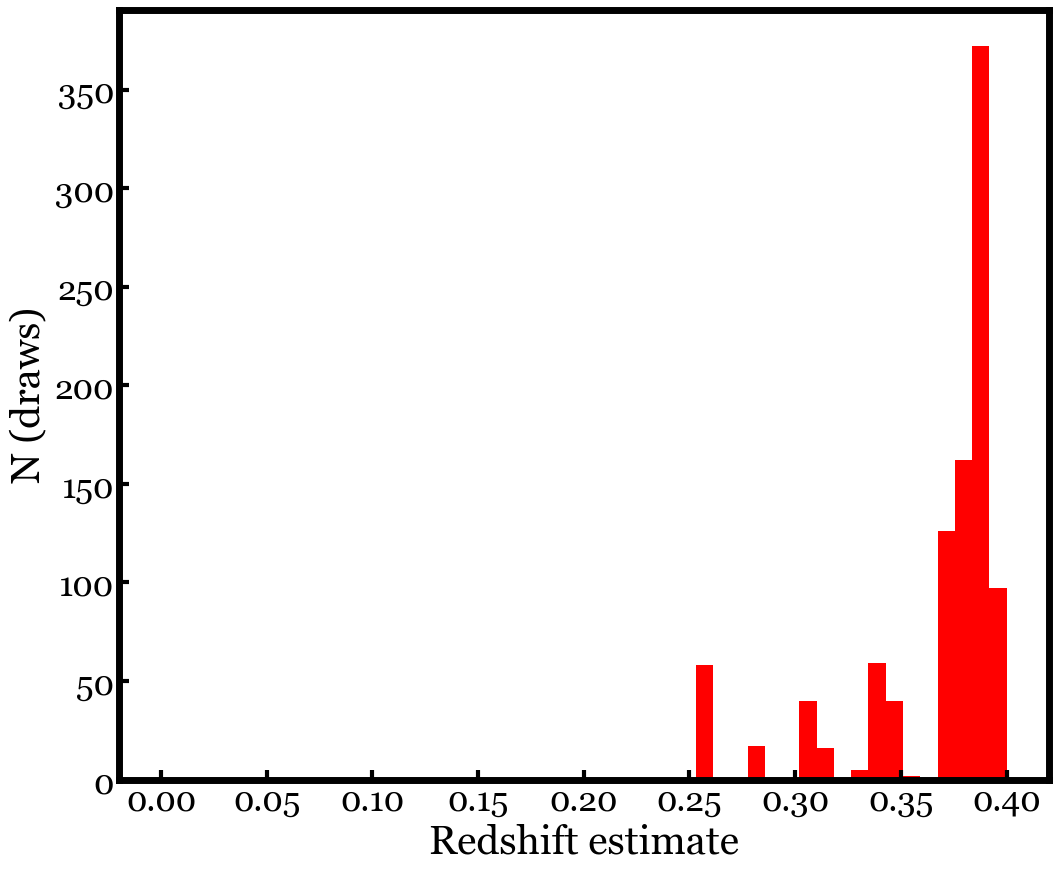

In [209]:
fig = plt.figure()
ax  = fig.add_subplot()

nbins = 50
bins = np.linspace(0, 0.4, nbins)

ax.hist(predicted_redshifts[:-1], bins = bins)
ax.axvline(predicted_redshifts[-1], color = 'black', linestyle = 'dashed')

ax.set_xlabel('Redshift estimate')
ax.set_ylabel('N (draws)')

# ax.set_xlim(0, 0.4)
# ax.set_xlim(0.13, 0.20)

In [83]:
np.percentile(predicted_redshifts[:-1], 50)

0.16701999306678772

In [31]:
median = np.percentile(predicted_redshifts[:-1], 50)
sigma  = np.percentile(predicted_redshifts[:-1], 86) - np.percentile(predicted_redshifts[:-1], 14)

In [32]:
def gaussian(x, mu, std):
    return 1/(np.sqrt(2 * np.pi) * std) * np.exp(-(x - mu)**2/(2 * std**2))

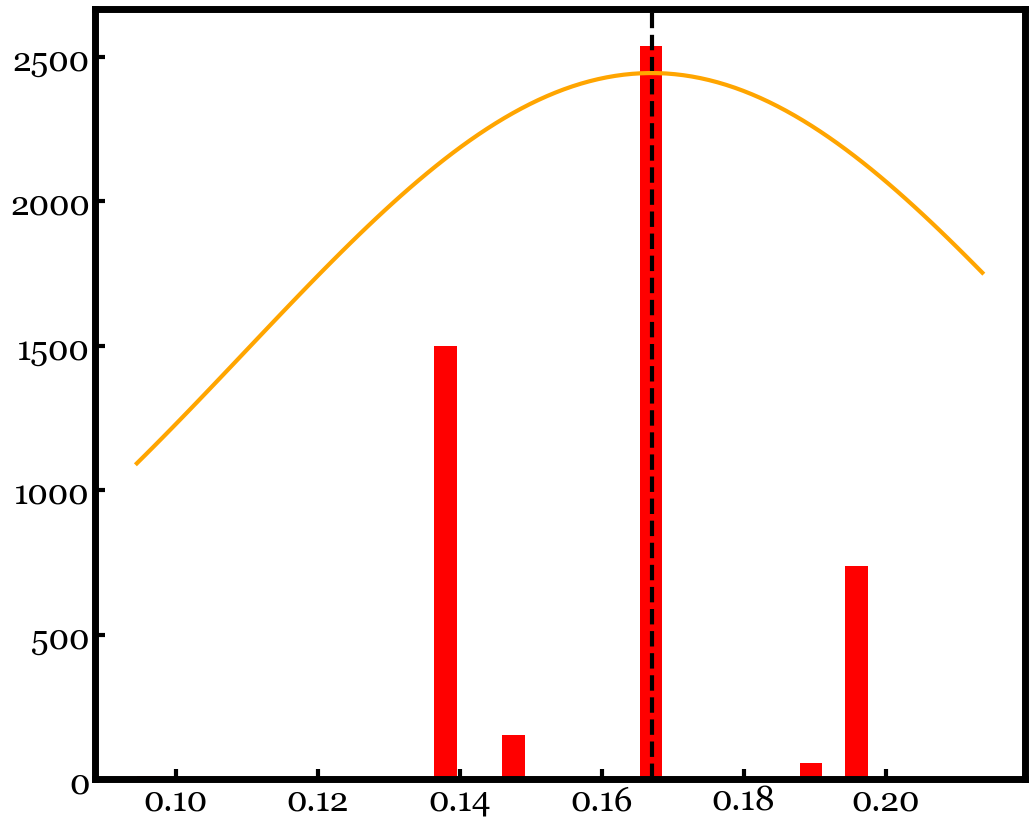

In [41]:
fig = plt.figure()
ax  = fig.add_subplot()

ax.hist(predicted_redshifts[:-1], bins = 'auto')
ax.axvline(predicted_redshifts[-1], color = 'black', linestyle = 'dashed')

zs = np.linspace(np.min(predicted_redshifts), np.max(predicted_redshifts), 100)
ax.plot(zs, gaussian(zs, median, sigma) * 350)

# 2D probability density

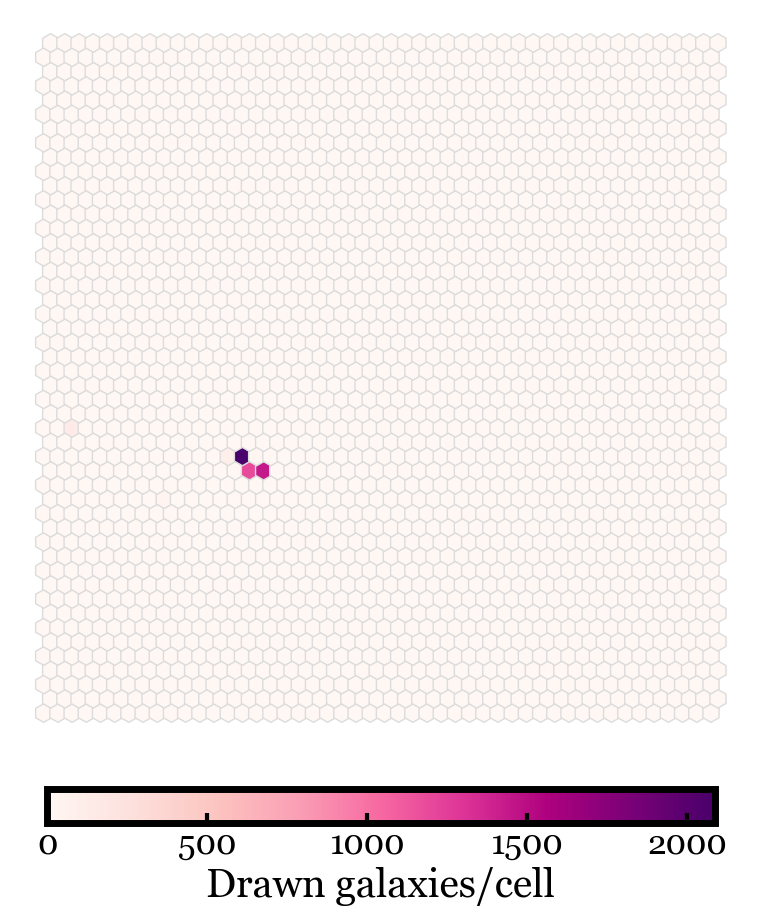

In [100]:
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

probability_map_array = np.empty((n_rows, n_columns), dtype = float)

for ind, val in np.ndenumerate(probability_map_array):
    probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell', shrink = 0.9)

# fig.savefig(f'{folder_name}/occupancy_map.png', bbox_inches = 'tight')

In [106]:
def probability_map(test_galaxy_bmus):
    
    hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

    hexmesh[0][1::2] += 1/2

    probability_map_array = np.empty((n_rows, n_columns), dtype = float)

    for ind, val in np.ndenumerate(probability_map_array):
        probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

    fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
    ax = fig.add_subplot()
    ax.axis('off')

    map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180)
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell', shrink = 0.9)

In [ ]:
galaxy_index = 3000

old_galaxy_means = KiDS_data_sec1[data_names][galaxy_index]

old_galaxy_stds  = KiDS_data_sec1[std_names][galaxy_index]
old_galaxy_stds = append_fields(old_galaxy_stds,
                               [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

In [ ]:
test_galaxy_500draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(5000)])
test_galaxy_500draws_plus_old = np.append(test_galaxy_500draws, [unstr(old_galaxy_means),], axis = 0)

In [ ]:
test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_500draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

In [ ]:
test_galaxy_plus_old_activation_map = SOM.get_surface_state(data = test_galaxy_500draws_plus_old)
test_galaxy_plus_old_bmus = SOM.get_bmus(activation_map = test_galaxy_plus_old_activation_map)

In [109]:
def test_probability_map(galaxy_index, n_draws = 5000):

    old_galaxy_means = KiDS_data_sec1[data_names][galaxy_index]

    old_galaxy_stds  = KiDS_data_sec1[std_names][galaxy_index]
    old_galaxy_stds = append_fields(old_galaxy_stds,
                                [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
    old_galaxy_stds = old_galaxy_stds.data[0]

    test_galaxy_n_draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(n_draws)])

    test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_n_draws)
    test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

    probability_map(test_galaxy_bmus)

In [149]:
all_stds = structured_to_unstructured(KiDS_data_sec1[std_names])

all_stds_sq = all_stds**2
stds_sq_sum = np.sum(all_stds_sq, axis = 1)
stds_sum = np.sqrt(stds_sq_sum)

n_draws = 5000

max_err_index = np.argmax(stds_sum)
min_err_index = np.argmin(stds_sum)

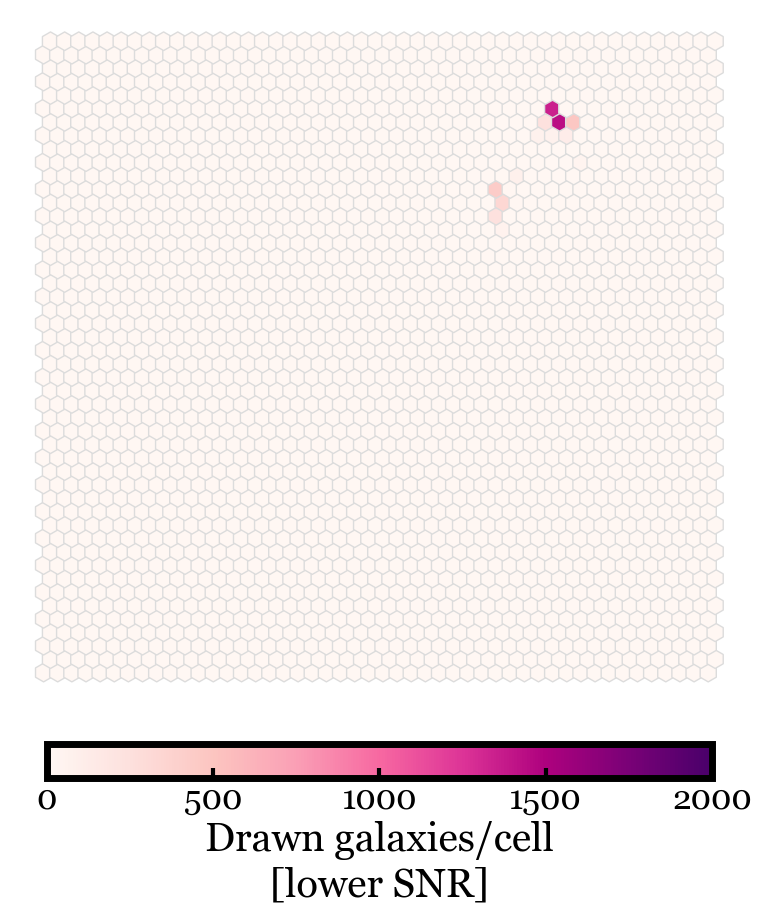

In [210]:
old_galaxy_means = KiDS_data_sec1[data_names][max_err_index]

old_galaxy_stds  = KiDS_data_sec1[std_names][max_err_index]
old_galaxy_stds = append_fields(old_galaxy_stds,
                            [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

test_galaxy_n_draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(n_draws)])

test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_n_draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                    np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

probability_map_array = np.empty((n_rows, n_columns), dtype = float)

for ind, val in np.ndenumerate(probability_map_array):
    probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180,
                 vmin = 0, vmax = 2000)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell\n[lower SNR]', shrink = 0.9)

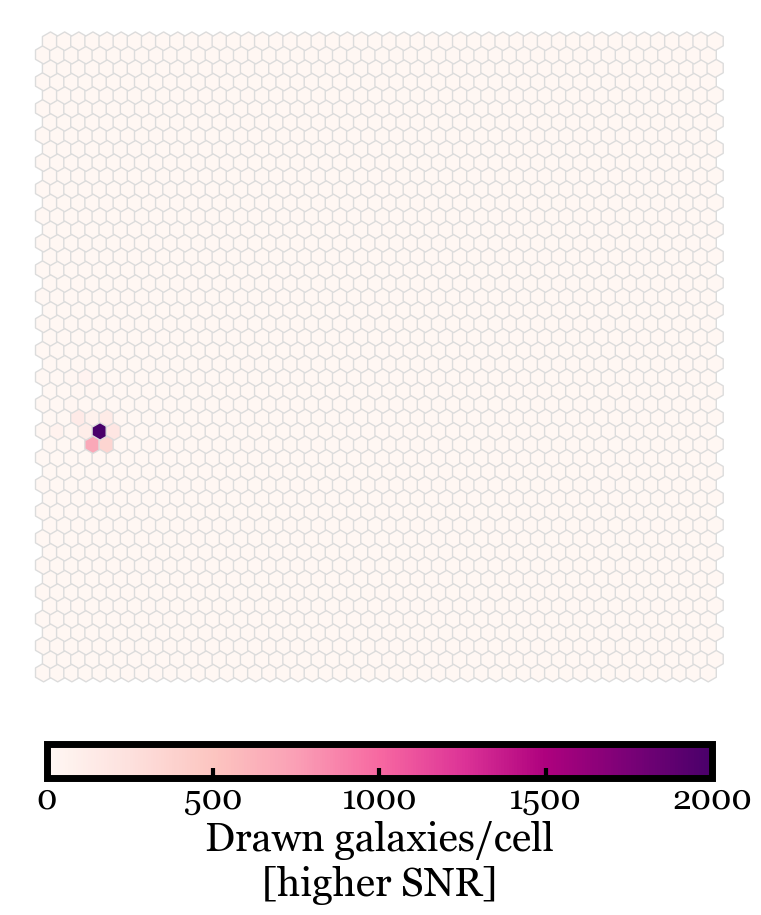

In [212]:
old_galaxy_means = KiDS_data_sec1[data_names][2500]

old_galaxy_stds  = KiDS_data_sec1[std_names][2500]
old_galaxy_stds = append_fields(old_galaxy_stds,
                            [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

test_galaxy_n_draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(n_draws)])

test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_n_draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                    np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

probability_map_array = np.empty((n_rows, n_columns), dtype = float)

for ind, val in np.ndenumerate(probability_map_array):
    probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180,
                 vmin = 0, vmax = 2000)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell\n[higher SNR]', shrink = 0.9)

l68/u68 from SOM cell

Add to statistical error in quadrature. Refer to La Torre et al. 2023

# Drawing many galaxies from one galaxy

In [3]:
folder = '/Users/leo/Projects/mass_profile_dg/saved_SOMs/09Aug24_mag_cut_20p5'
KiDS_predicted = FITS(f'{folder}/predicted_catalog.fits')[1]

labeled_map = np.load(f'{folder}/labeled_map.npy',
                      allow_pickle = True)
labeled_map_values = np.load(f'{folder}/labeled_map_values.npy',
                      allow_pickle = True)
data_bmus = np.load(f'{folder}/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load(f'{folder}/labeling_bmus.npy',
                      allow_pickle = True)

In [4]:
KiDS_catalog_path = '/Users/leo/Projects/mass_profile_dg/data_products/SOM_catalogs/KiDS/KiDS_SOM_panchrom_07Aug24/KiDS_SOM_panchrom_07Aug24_sec1.fits'

In [5]:
KiDS_data_sec1, _ = load_KiDS_data(KiDS_catalog_path)

In [7]:
column_names     = KiDS_data_sec1.dtype.names
color_names      = [name for name in column_names if name.endswith('col')]
color_std_names  = [name for name in column_names if name.endswith('col_err')]

data_names = ['r_mag'] + color_names
data_names += ['half_light_radius']
data_names += ['redshift']

std_names = ['r_mag_err'] + color_std_names
# std_names += ['half_light_radius_err']

In [8]:
def draw_new_galaxy(means, stds):
    return [np.random.normal(means[i], stds[i]) for i in range(len(means))]

In [9]:
#set parameters
n_columns      = 48
n_rows         = 48

maptype        = 'toroid'
gridtype       = 'hexagonal'

initialization = 'pca'

neighborhood   = 'gaussian'
std_coeff      = 0.5

verbose        = 2

compactsupport = False

#training parameters
epochs        = 50

radius0       = 0
radiusN       = 1
radiuscooling = 'exponential'

scale0        = 0.25
scaleN        = 0.01
scalecooling  = 'exponential'

SOM = somoclu.Somoclu(n_columns      = n_columns,
                      n_rows         = n_rows,
                      maptype        = maptype,
                      gridtype       = gridtype,
                      initialization = initialization,
                      neighborhood   = neighborhood,
                      std_coeff      = std_coeff,
                      verbose        = verbose,
                      compactsupport = compactsupport)

In [10]:
folder = '/Users/leo/Projects/mass_profile_dg/saved_SOMs/09Aug24_mag_cut_20p5'
SOM.codebook = np.load(f'{folder}/SOM_codebook.npy', allow_pickle = True)

In [ ]:
galaxy_index = 2500

old_galaxy_means = KiDS_data_sec1[data_names][galaxy_index]

old_galaxy_stds  = KiDS_data_sec1[std_names][galaxy_index]
old_galaxy_stds = append_fields(old_galaxy_stds,
                               [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

In [ ]:
test_galaxy_500draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(5000)])
test_galaxy_500draws_plus_old = np.append(test_galaxy_500draws, [unstr(old_galaxy_means),], axis = 0)

In [ ]:
test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_500draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

In [ ]:
test_galaxy_plus_old_activation_map = SOM.get_surface_state(data = test_galaxy_500draws_plus_old)
test_galaxy_plus_old_bmus = SOM.get_bmus(activation_map = test_galaxy_plus_old_activation_map)

In [ ]:
predicted_redshifts = np.array([])
predicted_mstars    = np.array([])
for bmu in test_galaxy_bmus:
    z, mstar = labeled_map[*bmu]
    predicted_redshifts = np.append(predicted_redshifts, z)
    predicted_mstars    = np.append(predicted_mstars, mstar)

In [ ]:
predicted_redshifts = np.array([])
predicted_mstars    = np.array([])
for bmu in test_galaxy_plus_old_bmus:
    z, mstar = labeled_map[*bmu]
    predicted_redshifts = np.append(predicted_redshifts, z)
    predicted_mstars    = np.append(predicted_mstars, mstar)

Text(0, 0.5, 'N (draws)')

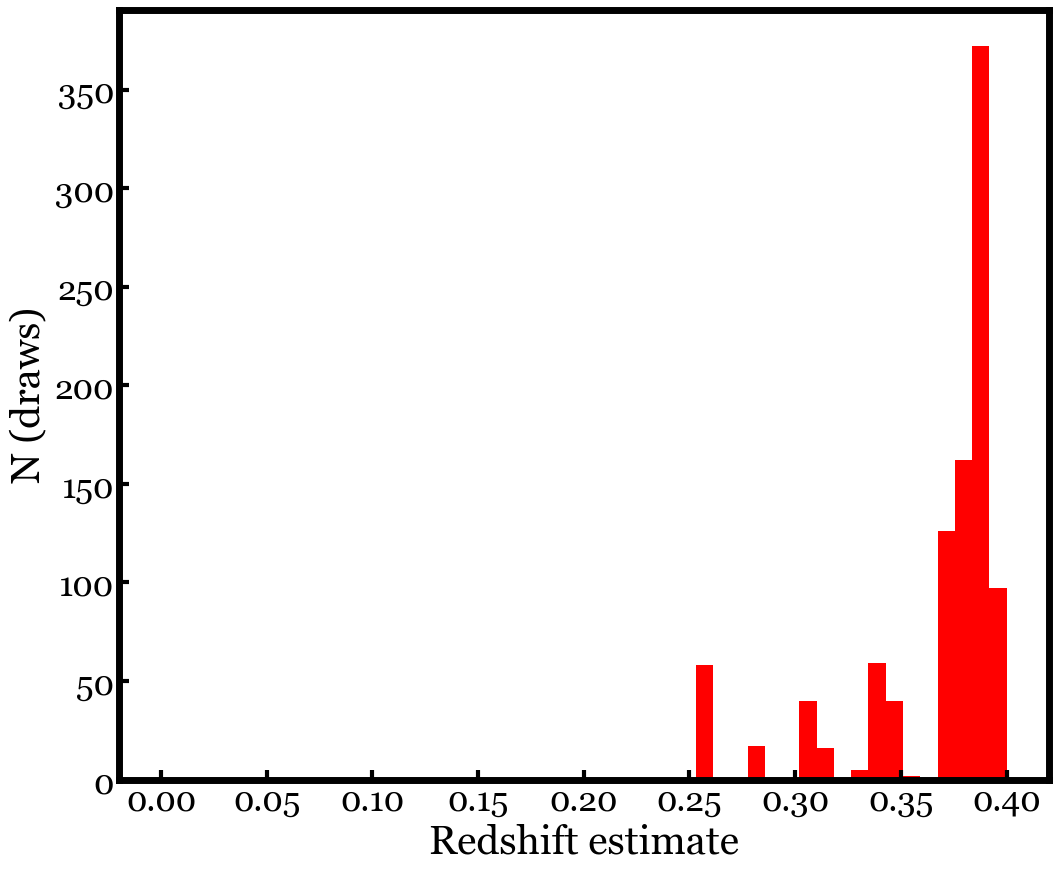

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot()

nbins = 50
bins = np.linspace(0, 0.4, nbins)

ax.hist(predicted_redshifts[:-1], bins = bins)
ax.axvline(predicted_redshifts[-1], color = 'black', linestyle = 'dashed')

ax.set_xlabel('Redshift estimate')
ax.set_ylabel('N (draws)')

# ax.set_xlim(0, 0.4)
# ax.set_xlim(0.13, 0.20)

In [ ]:
np.percentile(predicted_redshifts[:-1], 50)

0.16701999306678772

In [ ]:
median = np.percentile(predicted_redshifts[:-1], 50)
sigma  = np.percentile(predicted_redshifts[:-1], 86) - np.percentile(predicted_redshifts[:-1], 14)

In [ ]:
def gaussian(x, mu, std):
    return 1/(np.sqrt(2 * np.pi) * std) * np.exp(-(x - mu)**2/(2 * std**2))

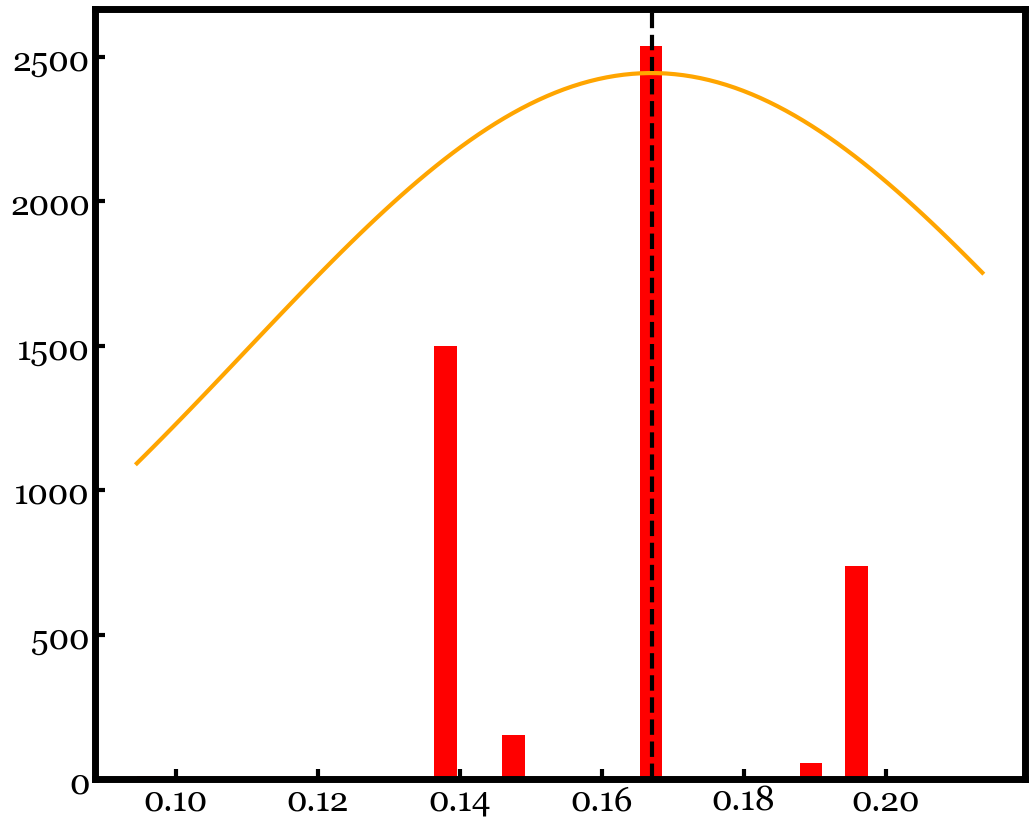

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot()

ax.hist(predicted_redshifts[:-1], bins = 'auto')
ax.axvline(predicted_redshifts[-1], color = 'black', linestyle = 'dashed')

zs = np.linspace(np.min(predicted_redshifts), np.max(predicted_redshifts), 100)
ax.plot(zs, gaussian(zs, median, sigma) * 350)

# 2D probability density

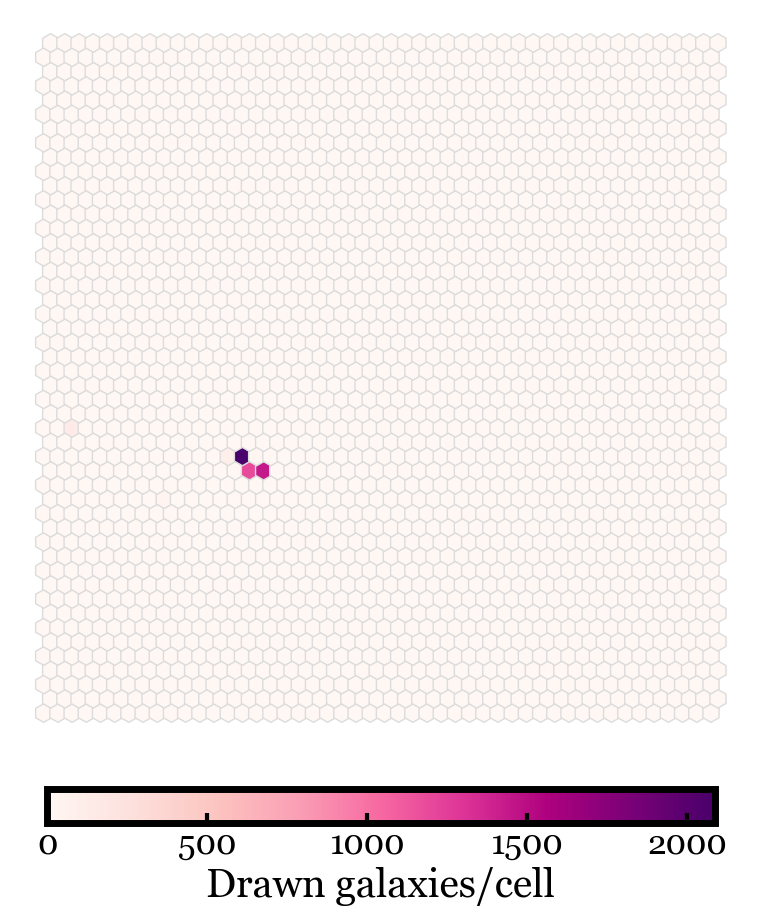

In [ ]:
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

probability_map_array = np.empty((n_rows, n_columns), dtype = float)

for ind, val in np.ndenumerate(probability_map_array):
    probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell', shrink = 0.9)

# fig.savefig(f'{folder_name}/occupancy_map.png', bbox_inches = 'tight')

In [ ]:
def probability_map(test_galaxy_bmus):
    
    hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

    hexmesh[0][1::2] += 1/2

    probability_map_array = np.empty((n_rows, n_columns), dtype = float)

    for ind, val in np.ndenumerate(probability_map_array):
        probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

    fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
    ax = fig.add_subplot()
    ax.axis('off')

    map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180)
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell', shrink = 0.9)

In [ ]:
galaxy_index = 3000

old_galaxy_means = KiDS_data_sec1[data_names][galaxy_index]

old_galaxy_stds  = KiDS_data_sec1[std_names][galaxy_index]
old_galaxy_stds = append_fields(old_galaxy_stds,
                               [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

In [ ]:
test_galaxy_500draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(5000)])
test_galaxy_500draws_plus_old = np.append(test_galaxy_500draws, [unstr(old_galaxy_means),], axis = 0)

In [ ]:
test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_500draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

In [ ]:
test_galaxy_plus_old_activation_map = SOM.get_surface_state(data = test_galaxy_500draws_plus_old)
test_galaxy_plus_old_bmus = SOM.get_bmus(activation_map = test_galaxy_plus_old_activation_map)

In [ ]:
def test_probability_map(galaxy_index, n_draws = 5000):

    old_galaxy_means = KiDS_data_sec1[data_names][galaxy_index]

    old_galaxy_stds  = KiDS_data_sec1[std_names][galaxy_index]
    old_galaxy_stds = append_fields(old_galaxy_stds,
                                [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
    old_galaxy_stds = old_galaxy_stds.data[0]

    test_galaxy_n_draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(n_draws)])

    test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_n_draws)
    test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

    probability_map(test_galaxy_bmus)

In [ ]:
all_stds = structured_to_unstructured(KiDS_data_sec1[std_names])

all_stds_sq = all_stds**2
stds_sq_sum = np.sum(all_stds_sq, axis = 1)
stds_sum = np.sqrt(stds_sq_sum)

n_draws = 5000

max_err_index = np.argmax(stds_sum)
min_err_index = np.argmin(stds_sum)

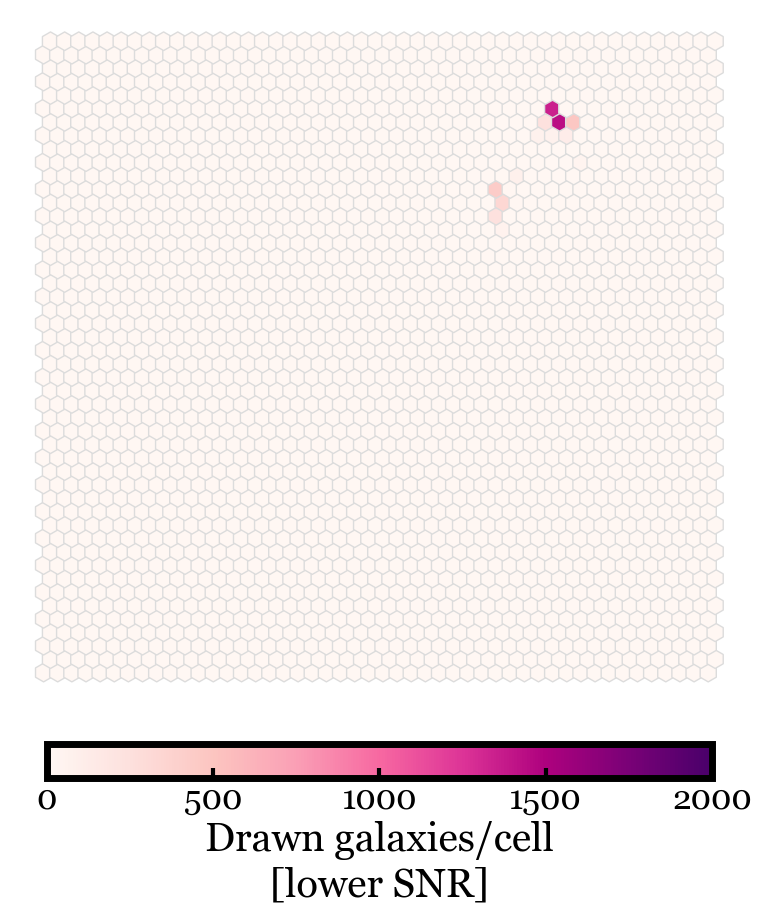

In [ ]:
old_galaxy_means = KiDS_data_sec1[data_names][max_err_index]

old_galaxy_stds  = KiDS_data_sec1[std_names][max_err_index]
old_galaxy_stds = append_fields(old_galaxy_stds,
                            [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

test_galaxy_n_draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(n_draws)])

test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_n_draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                    np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

probability_map_array = np.empty((n_rows, n_columns), dtype = float)

for ind, val in np.ndenumerate(probability_map_array):
    probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180,
                 vmin = 0, vmax = 2000)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell\n[lower SNR]', shrink = 0.9)

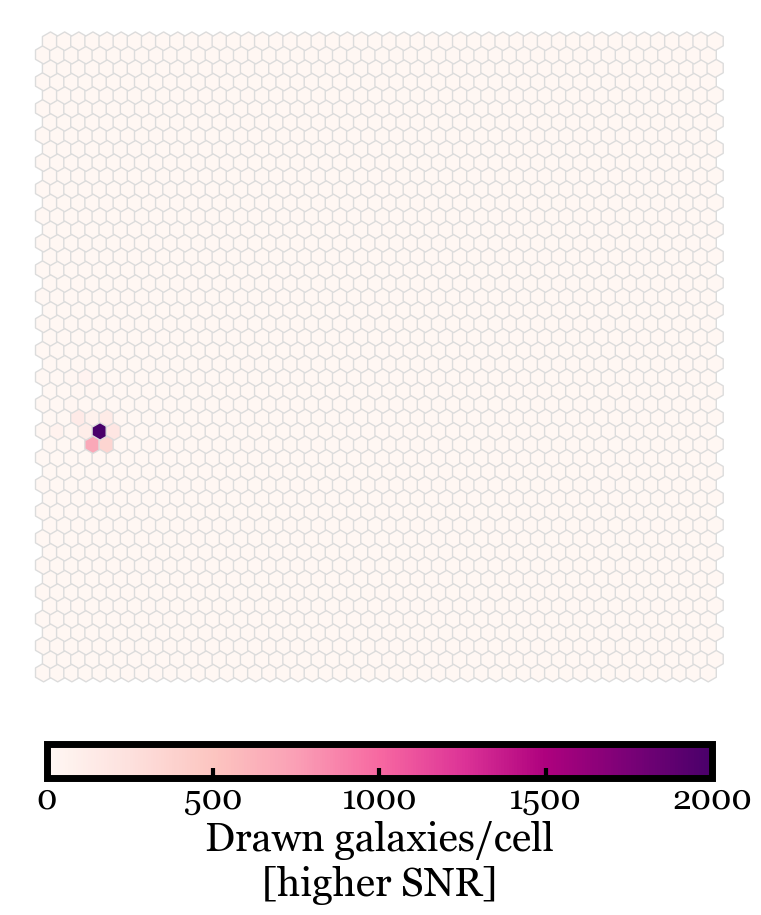

In [ ]:
old_galaxy_means = KiDS_data_sec1[data_names][2500]

old_galaxy_stds  = KiDS_data_sec1[std_names][2500]
old_galaxy_stds = append_fields(old_galaxy_stds,
                            [ 'half_light_radius_err', 'redshift_err'], [0., 0.], dtypes = ['>f4', '>f4'])
old_galaxy_stds = old_galaxy_stds.data[0]

test_galaxy_n_draws = np.array([draw_new_galaxy(old_galaxy_means, old_galaxy_stds) for _ in range(n_draws)])

test_galaxy_activation_map = SOM.get_surface_state(data = test_galaxy_n_draws)
test_galaxy_bmus = SOM.get_bmus(activation_map = test_galaxy_activation_map)

hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                    np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

probability_map_array = np.empty((n_rows, n_columns), dtype = float)

for ind, val in np.ndenumerate(probability_map_array):
    probability_map_array[ind] = np.sum(np.sum(test_galaxy_bmus == ind, axis = 1) == 2)

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = probability_map_array, marker = 'h', cmap = 'RdPu', edgecolors = 'gainsboro', s = 180,
                 vmin = 0, vmax = 2000)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'Drawn galaxies/cell\n[higher SNR]', shrink = 0.9)